In [1]:
import math
import numpy as np
from scipy.fft import fft
import src.utility.utility_frequency_analysis as sDFT
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels.api as sm
import src.OnlineSLE.IIAI_synthetic as gensyn
from src.utility.utility import update_array

In [2]:
data1 = gensyn.generate_syn1(residual_rate=0.05, is_export=False)
win1 = math.ceil(int(max(data1['ground_truth'])) * 5) 
data2 = gensyn.generate_syn2(residual_rate=0.05, is_export=False)
win2 = math.ceil(int(max(data2['ground_truth'])) * 5) 

In [3]:
def s_sdf_SLE(input_ts,window_size):
    results = []
    buffer = input_ts[:window_size]
    start_fft = fft(buffer)
    results.append(start_fft)
    N = len(start_fft)
    k = np.arange(N)
    twiddle = np.exp(2j * np.pi * k / N)
    for idx, newest_x in enumerate(input_ts[window_size:]):
        oldest_x = buffer[0]
        buffer = update_array(buffer, newest_x)
        start_fft = sDFT.update_sDFT(start_fft, oldest_x, newest_x, twiddle)
        results.append(start_fft)
    return results

def s_scipy_fft(input_ts,window_size):
    results = []
    for idx in range(len(input_ts) - window_size + 1):
        buffer = input_ts[idx:window_size + idx]
        results.append(fft(buffer))
    return results

In [4]:
error_results = []
for ts,name,window_size in zip([data1['ts'],data2['ts']], ['Syn1', 'Syn2'], [win1,win2]):
    ts = zscore(ts)
    sdft_results = s_sdf_SLE(ts, window_size)
    fft_results = s_scipy_fft(ts, window_size)
    error_result = []
    for sdft_result, fft_result in zip(sdft_results, fft_results):
        error_result.append(abs(sdft_result[0] - fft_result[0]))
    error_results.append(error_result)

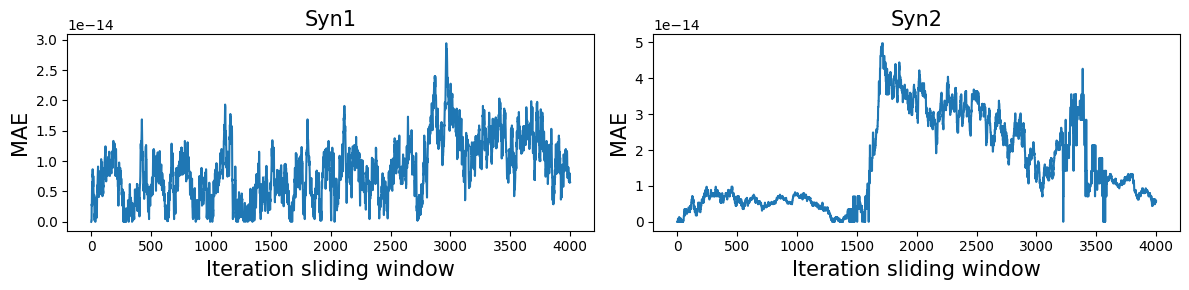

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

axs[0].plot(error_results[0][:4000])
axs[0].set_title('Syn1', fontsize=15)
axs[0].set_xlabel('Iteration sliding window', fontsize=15)
axs[0].set_ylabel('MAE', fontsize=15)
# axs[0].tick_params(axis='both', which='major', labelsize=15)

plt.plot(error_results[1][:4000])
axs[1].set_title('Syn2', fontsize=15)
axs[1].set_xlabel('Iteration sliding window', fontsize=15)
axs[1].set_ylabel('MAE', fontsize=15)
# axs[1].tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()


In [6]:
sm.stats.acorr_ljungbox(error_results[0][:4000], lags=[20], return_df=True)

,lb_stat,lb_pvalue
20,49458.25485,0.0
